# Project: Finding Lane Lines on the Road

## Import Packages

In [277]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


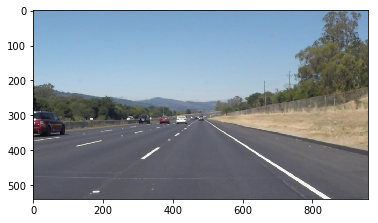

In [278]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [279]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Let's build the pipeline to work on the images in the directory "test_images".

In [280]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Let's build the pipeline that will draw lane lines on the test_images and run the solution on all test_images. Copies of images will be placed into the  `test_images_output` directory.

In [281]:
from os.path import isdir

!mkdir test_images_output
output_dir = 'test_images_output/'
if not isdir(output_dir):
    raise Exception("Test images Ouput directory doesn't exist!")

mkdir: test_images_output: File exists


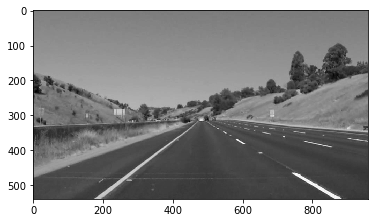

In [282]:
# Read in and grayscale the image
filename = "whiteCarLaneSwitch.jpg"
image = mpimg.imread('test_images/' + filename)
gray = grayscale(image)
plt.imshow(gray, cmap='gray')

mpimg.imsave(output_dir + "gray_" + filename, gray, cmap='gray')

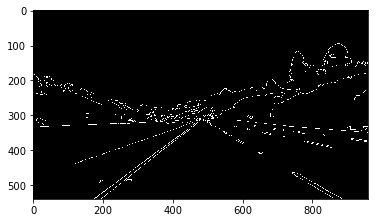

In [283]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

mpimg.imsave(output_dir + "canny_" + filename, edges, cmap='gray')

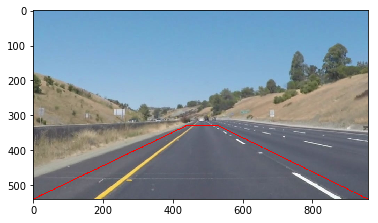

In [284]:
# let's define a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(440, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
copy_color_img = image.copy()
cv2.polylines(copy_color_img,[vertices], True,(255, 0, 0), thickness=2)
plt.imshow(copy_color_img)

mpimg.imsave(output_dir + "roi_" + filename, copy_color_img)

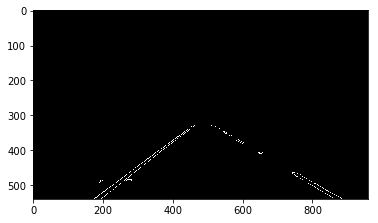

In [285]:
# let's create a masked edges image
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges, cmap='gray')

mpimg.imsave(output_dir + "masked_edges_" + filename, masked_edges, cmap='gray')

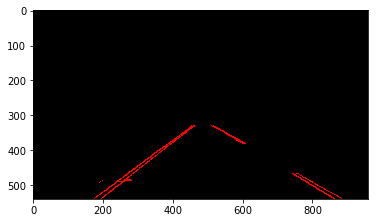

In [286]:
# Define the Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 11 #minimum number of pixels making up a line
max_line_gap = 16    # maximum gap in pixels between connectable line segments
line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_img)

mpimg.imsave(output_dir + "line_img_" + filename, line_img)

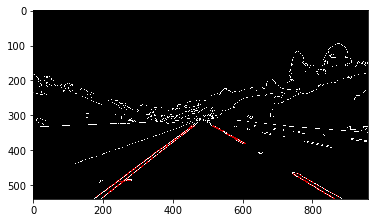

In [287]:
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = weighted_img(color_edges, line_img)
plt.imshow(lines_edges)

mpimg.imsave(output_dir + "line_edges_" + filename, lines_edges)

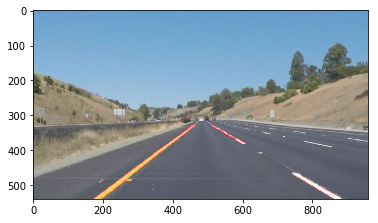

In [288]:
# Create a "color" copy of the initial image to combine with line image
copy_color_img = image.copy()

# Draw the lines on the edge image
color_lines = weighted_img(copy_color_img, line_img)
plt.imshow(color_lines)

mpimg.imsave(output_dir + "color_lines_" + filename, color_lines)

## Test on Videos

Let's draw lines over video. 
Let's test the solution on two provided videos:

solidWhiteRight.mp4

solidYellowLeft.mp4

If you get an error that looks like this:
```
NeedDownloadError: Need ffmpeg exe. 
```
You can download it by calling: 
```
imageio.plugins.ffmpeg.download()
```
Follow the instructions in the error message and check out this [forum](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) post for more troubleshooting tips across operating systems.

In [289]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [290]:
def process_image(image):
    # NOTE: The output should be a color image (3 channel) for processing video below
    # we should return the final output (image where lines are drawn on lanes)
    
    # Read in and grayscale the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 11 #minimum number of pixels making up a line
    max_line_gap = 16    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line_img)
    
    result = color_lines

    
    return result

Let's try the one with the solid white lane on the right first ...

In [291]:
!mkdir test_videos_output
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

mkdir: test_videos_output: File exists
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 77.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.95 s, sys: 658 ms, total: 3.61 s
Wall time: 3.21 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

**NOTE**: the video may fail to play in Safari but works well in Chrome.

In [294]:
HTML("""
<video width="960" height="540" controls>
  <source 
      src="{0}"
      type="video/mp4">
</video>
""".format(white_output))

## Improve the draw_lines() function

Let's define a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, let's try to average and/or extrapolate the line segments detected to map out the full extent of the lane lines. An example of the result can be seen in the video "P1_example.mp4".
Let's modify the draw_lines function accordingly and try re-running the pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.
Now for the one with the solid yellow lane on the left. This one's more tricky!

In [401]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def improved_draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_line_x1 = img.shape[1]
    left_line_y1 = 0
    left_line_x2 = 0
    left_line_y2 = img.shape[0]
    
    right_line_x1 = img.shape[1]
    right_line_y1 = img.shape[0]
    right_line_x2 = 0
    right_line_y2 = 0
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            isLeftLine = (slope < 0)
            if isLeftLine:
#                 color = [0, 122, 255]
#                 cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                
                # find the 2 lines bounds for all left road lines
                if x1 < left_line_x1:
                    left_line_x1 = x1
                
                if y1 > left_line_y1:
                    left_line_y1 = y1
                
                if x2 > left_line_x2:
                    left_line_x2 = x2
                
                if y2 < left_line_y2:
                    left_line_y2 = y2                
            else:
#                 color = [0, 122, 255]
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                print(x1, y1, x2, y2)
                
                # find the 2 lines bounds for all right road lines
                if x1 < right_line_x1:
                    right_line_x1 = x1
                
                if y1 < right_line_y1:
                    right_line_y1 = y1
                
                if x2 > right_line_x2:
                    right_line_x2 = x2
                
                if y2 > right_line_y2:
                    right_line_y2 = y2
                
#     print('x1={}, y1={}, x2={}, y2={}'.format(right_line_x1, right_line_y1, right_line_x2, right_line_y2))       
    # Now that we have these extreme points, then let's find the points on the ROI 
    # using lines passing through these points.
    # Left line
    m1 = (left_line_y2 - left_line_y1)/(left_line_x2-left_line_x1)
    b1 = left_line_y1 - m1 * left_line_x1
    
    # the bottom point
    left_line_y1 = img.shape[1]
#     print(left_line_y1, b1, m1)
    left_line_x1 = int((left_line_y1 - b1) / m1)
    color2=[255, 0, 0]
    cv2.line(img, (left_line_x1, left_line_y1), (left_line_x2, left_line_y2), color2, thickness)
    
    # Right line
    m2 = (right_line_y2 - right_line_y1)/(right_line_x2 - right_line_x1)
    b2 = right_line_y1 - m2 * right_line_x1
    
    # the upper point
    right_line_y1 = 330
    right_line_x1 = int((right_line_y1 - b2) / m2)
    
    # the bottom point
    right_line_y2 = img.shape[1]
    right_line_x2 = int((right_line_y2 - b2) / m2)
#     cv2.line(img, (right_line_x1, right_line_y1), (right_line_x2, right_line_y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    improved_draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [381]:
def improved_process_image(image):
    # NOTE: The output should be a color image (3 channel) for processing video below
    # we should return the final output (image where lines are drawn on lanes)
    
    # Read in and grayscale the image
    gray = grayscale(image)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # let's define a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(440, 330), (530, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # let's create a masked edges image
    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color copy of the initial image to combine with line image
    copy_color_img = image.copy()

    # Draw the lines on the edge image
    color_lines = weighted_img(copy_color_img, line_img)
    
    result = color_lines

    
    return result

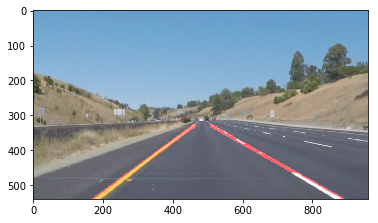

In [397]:
files = os.listdir("test_images/")
for filename in files:
    image = mpimg.imread('test_images/' + filename)
    output_image = improved_process_image(image)
    plt.imshow(output_image)

    mpimg.imsave(output_dir + "color_lines_" + filename, output_image)

In [402]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,1)
# clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(improved_process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

658 427 758 497
665 425 774 496
523 331 564 357
527 330 581 367
523 330 577 369
673 428 740 473
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 31%|███       | 8/26 [00:00<00:00, 73.84it/s]

658 427 758 497
665 425 774 496
523 331 564 357
527 330 581 367
523 330 577 369
673 428 740 473
685 439 831 533
678 441 813 535
699 447 764 488
523 331 576 369
528 330 586 371
527 330 581 372
524 330 586 373
678 440 748 491
730 467 771 493
704 459 819 539
716 458 838 537
524 330 594 375
528 334 593 377
526 334 590 377
713 457 839 539
767 502 815 536
528 330 592 375
705 460 753 494
526 334 576 367
749 480 819 524
738 480 808 531
526 332 601 380
541 345 597 382
526 331 600 379
750 491 800 525
527 332 582 370
797 510 842 539
526 333 603 387
568 357 609 387
528 334 604 387
796 510 841 537
532 333 584 370
195 488 241 488
530 333 583 370
528 333 618 391
566 362 614 393
527 334 591 378
529 332 571 359
554 352 618 392
530 333 571 360
529 334 623 400
529 336 576 364
531 333 576 363
548 349 594 378
530 337 570 362
531 333 581 366
529 335 575 366
530 335 580 366
532 333 581 365
531 336 580 369
531 333 586 368
532 333 583 369
537 338 582 369
625 393 678 426
619 396 666 427
539 336 591 372
534 338 

 96%|█████████▌| 25/26 [00:00<00:00, 76.04it/s]

788 494 860 537
525 331 610 382
775 496 839 538
529 330 603 384
527 333 583 368
565 354 609 384
817 512 861 538
775 495 826 529
526 330 571 358
526 332 619 388
544 345 614 390
567 359 619 389
538 340 626 393
527 330 575 360
527 332 571 362
529 330 574 359
540 339 594 377
527 332 574 364
528 330 580 362
534 335 580 364
528 330 585 365
528 331 581 367
609 387 649 412
613 384 657 410
608 386 650 412
535 335 584 367
611 384 657 411
531 330 585 366
617 391 665 422
625 390 676 421
530 333 590 370
530 330 590 369
618 392 662 421
624 390 668 417
542 341 587 370
530 331 586 367
621 390 671 419
635 397 696 435
629 399 686 436
531 333 597 374
531 331 597 373
640 407 680 433
642 407 713 453
647 405 724 451
533 332 600 379
533 335 575 362
651 406 692 431
642 408 712 453
533 333 573 359
665 416 759 475
534 337 580 366
656 416 733 468
534 336 581 364
690 430 754 471
534 334 580 363
696 442 740 472
717 446 759 474
662 415 719 448


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 395 ms, sys: 142 ms, total: 536 ms
Wall time: 630 ms
